In [158]:
import sys
!{sys.executable} -m pip install mediapipe

In [159]:
import mediapipe as mp
print("mediapipe version:", mp.__version__)

mediapipe version: 0.10.21


In [160]:
import os, urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

print("mediapipe version:", mp.__version__)

# Hand Landmarker model (Tasks API)
MODEL_URL  = "https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task"
MODEL_DIR  = r"C:\models"                      # <- change if you want
MODEL_PATH = os.path.join(MODEL_DIR, "hand_landmarker.task")
os.makedirs(MODEL_DIR, exist_ok=True)

# Download the model if missing
if not os.path.exists(MODEL_PATH):
    print("Downloading model…")
    urllib.request.urlretrieve(MODEL_URL, MODEL_PATH)
    print("Saved:", MODEL_PATH)
else:
    print("Model present:", MODEL_PATH)


mediapipe version: 0.10.21
Model present: C:\models\hand_landmarker.task


In [161]:
# EDIT THIS to your actual file (include .png/.jpg/.jpeg etc.)
IMAGE_PATH = r"C:\flir_capture\calibration\tom_hand_media_pipe\tom_hand.jpg"

assert os.path.exists(IMAGE_PATH), f"Image not found: {IMAGE_PATH}"

# Create the mp.Image directly from file (avoids path issues with cv2)
mp_image = mp.Image.create_from_file(IMAGE_PATH)

# For drawing with OpenCV/matplotlib, get a NumPy RGB view
img_rgb = mp_image.numpy_view()
print("Image shape (H, W, C):", img_rgb.shape)


Image shape (H, W, C): (480, 640, 3)


In [162]:
base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=2,                          # detect up to 2 hands
    min_hand_detection_confidence=0.5,
    min_hand_presence_confidence=0.5,
    min_tracking_confidence=0.5
)

detector = vision.HandLandmarker.create_from_options(options)
result = detector.detect(mp_image)

num_hands = 0 if not result.hand_landmarks else len(result.hand_landmarks)
print("Hands detected:", num_hands)

Hands detected: 1


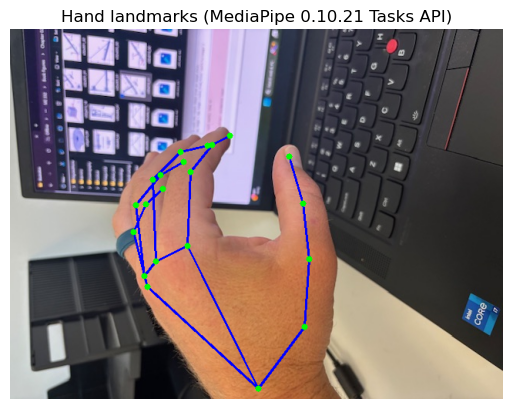

In [163]:
# Minimal MediaPipe hand topology (21-pt) connection list
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),          # Thumb
    (0,5),(5,6),(6,7),(7,8),          # Index
    (5,9),(9,10),(10,11),(11,12),     # Middle
    (9,13),(13,14),(14,15),(15,16),   # Ring
    (13,17),(17,18),(18,19),(19,20),  # Pinky
    (0,17)                             # Palm edge
]

# Copy image for drawing (OpenCV expects BGR)
draw_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
h, w, _ = draw_bgr.shape

if result.hand_landmarks:
    for hand in result.hand_landmarks:
        pts = [(int(lm.x * w), int(lm.y * h)) for lm in hand]

        # Draw connections
        for i, j in HAND_CONNECTIONS:
            if 0 <= i < len(pts) and 0 <= j < len(pts):
                cv2.line(draw_bgr, pts[i], pts[j], (255, 0, 0), 2)

        # Draw landmarks
        for x, y in pts:
            cv2.circle(draw_bgr, (x, y), 4, (0, 255, 0), -1)
else:
    print("No hands found. Try a larger/clearer hand region.")

# Show with matplotlib (convert back to RGB)
plt.imshow(cv2.cvtColor(draw_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Hand landmarks (MediaPipe 0.10.21 Tasks API)")
plt.show()


In [164]:
if result.hand_landmarks:
    first_hand = result.hand_landmarks[0]     # 21 landmarks
    coords = np.array([[lm.x, lm.y, lm.z] for lm in first_hand])  # normalized coords
    print("First hand landmarks (21 x 3: x,y,z in [0..1] image coords):")
    print(coords)
else:
    print("No landmarks available.")

First hand landmarks (21 x 3: x,y,z in [0..1] image coords):
[[ 5.04619360e-01  9.71487164e-01  1.44666342e-06]
 [ 5.97561121e-01  8.05088043e-01 -8.95822495e-02]
 [ 6.06724262e-01  6.20972395e-01 -1.01396769e-01]
 [ 5.95144391e-01  4.70974118e-01 -8.37962851e-02]
 [ 5.65960884e-01  3.44340533e-01 -5.38335852e-02]
 [ 3.59412611e-01  5.86951375e-01 -5.13976440e-02]
 [ 3.66825402e-01  3.85508657e-01 -9.59701743e-03]
 [ 4.10873681e-01  3.13623399e-01  2.75963768e-02]
 [ 4.46447462e-01  2.89208978e-01  5.45201674e-02]
 [ 2.96671569e-01  6.27129614e-01  1.85613297e-02]
 [ 2.90182889e-01  4.06626105e-01  5.49754016e-02]
 [ 3.45908403e-01  3.31612468e-01  7.83699229e-02]
 [ 4.01035964e-01  3.14639509e-01  9.67943072e-02]
 [ 2.72979617e-01  6.67537987e-01  8.63069221e-02]
 [ 2.55811304e-01  4.76240486e-01  1.18961543e-01]
 [ 3.05486590e-01  3.94185364e-01  1.26304314e-01]
 [ 3.52762282e-01  3.59694958e-01  1.30411476e-01]
 [ 2.78570533e-01  6.97895050e-01  1.48000151e-01]
 [ 2.50068843e-01  5.

In [165]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
from config import path_to_repository
from analysis import DLC3DBendAngles
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [167]:
if result.hand_landmarks:
    first_hand = result.hand_landmarks[0]   # 21 landmarks
    coords = np.array([[lm.x, lm.y, lm.z] for lm in first_hand])  # shape (21,3)

    # Column names
    columns = ["x", "y", "z"]

    # Landmark labels per MediaPipe documentation
    landmark_names = [
        "WRIST",
        "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP",
        "INDEX_MCP", "INDEX_PIP", "INDEX_DIP", "INDEX_TIP",
        "MIDDLE_MCP", "MIDDLE_PIP", "MIDDLE_DIP", "MIDDLE_TIP",
        "RING_MCP", "RING_PIP", "RING_DIP", "RING_TIP",
        "PINKY_MCP", "PINKY_PIP", "PINKY_DIP", "PINKY_TIP"
    ]

    # Build DataFrame
    df_hand = pd.DataFrame(coords, columns=columns, index=landmark_names)

    print(df_hand.head())  # first few rows
else:
    print("No landmarks available.")





                  x         y         z
WRIST      0.504619  0.971487  0.000001
THUMB_CMC  0.597561  0.805088 -0.089582
THUMB_MCP  0.606724  0.620972 -0.101397
THUMB_IP   0.595144  0.470974 -0.083796
THUMB_TIP  0.565961  0.344341 -0.053834


In [168]:

# 3) From an in-memory DataFrame (like MediaPipe output you built)
df_hand = pd.DataFrame(coords, columns=["x","y","z"], index=landmark_names)
cam = DLC3DBendAngles(
    df_hand,   # can be CSV path(s) or a DataFrame (per the updated __init__)
    bodyparts={
        "hand":    "WRIST",       # MediaPipe name → canonical "hand"
        "MCP":     "INDEX_MCP",   # index finger MCP
        "PIP":     "INDEX_PIP",   # index finger PIP
        "forearm": "FOREARM",     # if you have it; otherwise see note below
    }
)

scorer = "mp"
tuples, values = [], []
for name, (x,y,z) in zip(landmark_names, coords):
    tuples += [(scorer,name,"x"), (scorer,name,"y"), (scorer,name,"z")]
    values += [x,y,z]
df_row = pd.DataFrame([values], columns=pd.MultiIndex.from_tuples(tuples))

cam = DLC3DBendAngles(df_row, bodyparts={
    "hand":"WRIST", "MCP":"INDEX_MCP", "PIP":"INDEX_PIP"
})


In [169]:
#Calculte bend angles from DLC 3d trianglulated data

# --- MCP bend ---
hand_pts = cam.get_points("hand")
mcp_pts  = cam.get_points("MCP")
pip_pts  = cam.get_points("PIP")

v1_mcp = cam.vector(hand_pts, mcp_pts)  # hand→MCP
v2_mcp = cam.vector(mcp_pts, pip_pts)   # MCP→PIP
angles_mcp = cam.angle_from_vectors(v1_mcp, v2_mcp) # old way of calculting angle without projection onto wrist plane





# --- Add both angles to a copy of the DataFrame ---
df_out = cam.df.copy()
df_out[("metric", "mcp_bend_deg", "deg")]   = angles_mcp

cam.add_dataframe(df_out)

mp                                                              \
      WRIST                     THUMB_CMC                     THUMB_MCP   
          x         y         z         x         y         z         x   
0  0.504619  0.971487  0.000001  0.597561  0.805088 -0.089582  0.606724   

                                 ...                                        \
                       THUMB_IP  ... PINKY_PIP                   PINKY_DIP   
          y         z         x  ...         x         y       z         x   
0  0.620972 -0.101397  0.595144  ...  0.250069  0.549893  0.1695  0.275499   

                                                          metric  
                      PINKY_TIP                     mcp_bend_deg  
          y         z         x         y         z          deg  
0  0.474495  0.172884   0.31078  0.431727  0.177221    29.480342  

[1 rows x 64 columns]

In [170]:
import os

# Define paths (use raw strings or forward slashes on Windows)
video_path = r"C:\flir_capture\calibration\tom_hand_media_pipe\tom_hand.mov"
output_dir = r"C:\flir_capture\calibration\tom_hand_media_pipe\frames"

# Make sure output folder exists
os.makedirs(output_dir, exist_ok=True)

# Run ffmpeg to grab 1 frame per second
!ffmpeg -i "{video_path}"  "{output_dir}/frame_%03d.jpg"

ffmpeg version 2025-07-23-git-829680f96a-essentials_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 15.1.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-dxva2 --enable-d3d11va --enable-d3d12va --enable-ffnvcodec --enable-libvpl --enable-nvdec --enable-nvenc --enable-vaapi --enable-openal --enable-libgme --enable-libopenmpt --enable-lib

In [171]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from mediapipe.tasks.python import vision as mp_vision
from mediapipe.tasks.python.core.base_options import BaseOptions

# ---------- Paths ----------
VIDEO_PATH = r"C:\flir_capture\calibration\tom_hand_media_pipe\tom_hand.mov"
#MODEL_PATH = r"C:\flir_capture\calibration\tom_hand_media_pipe\hand_landmarker.task"
SCORER     = "mp"  # level-0 column label; arbitrary

assert os.path.exists(VIDEO_PATH), f"Video not found: {VIDEO_PATH}"
assert os.path.exists(MODEL_PATH), "Missing 'hand_landmarker.task' model file."

# MediaPipe landmark names (0..20)
LM_NAMES = [
    "WRIST",
    "THUMB_CMC","THUMB_MCP","THUMB_IP","THUMB_TIP",
    "INDEX_MCP","INDEX_PIP","INDEX_DIP","INDEX_TIP",
    "MIDDLE_MCP","MIDDLE_PIP","MIDDLE_DIP","MIDDLE_TIP",
    "RING_MCP","RING_PIP","RING_DIP","RING_TIP",
    "PINKY_MCP","PINKY_PIP","PINKY_DIP","PINKY_TIP",
]

# DLC-style MultiIndex columns
def make_dlc_cols(scorer, names):
    t = []
    for nm in names:
        t += [(scorer, nm, "x"), (scorer, nm, "y"), (scorer, nm, "z")]
    return pd.MultiIndex.from_tuples(t)

dlc_cols = make_dlc_cols(SCORER, LM_NAMES)

# Create detector in VIDEO mode (temporal tracking = fewer dropouts)
opts = mp_vision.HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=MODEL_PATH),
    running_mode=mp_vision.RunningMode.VIDEO,
    num_hands=1,
    min_hand_detection_confidence=0.3,   # relax if you want more (noisier) hits
    min_hand_presence_confidence=0.3,
    min_tracking_confidence=0.3
)
detector = mp_vision.HandLandmarker.create_from_options(opts)

# --- Read video ---
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f"Could not open video: {VIDEO_PATH}"

fps = cap.get(cv2.CAP_PROP_FPS)
fps = fps if fps and fps > 0 else 30.0  # fallback
rows = []
index = []   # could be frame number or timestamp
frame_idx = 0

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break

    # OpenCV BGR -> RGB for MediaPipe
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

    # monotonically increasing timestamp in ms
    ts_ms = int((frame_idx / fps) * 1000.0)

    result = detector.detect_for_video(mp_image, ts_ms)

    if not result.hand_landmarks:
        rows.append(np.full(len(dlc_cols), np.nan, dtype=float))
    else:
        hand = result.hand_landmarks[0]
        vals = []
        for lm in hand:
            vals.extend([lm.x, lm.y, lm.z])  # normalized coords
        rows.append(np.array(vals, dtype=float))

    index.append(frame_idx)  # or use ts_ms/1000.0 for seconds
    frame_idx += 1

cap.release()

# Build DataFrame: rows = frames, columns = DLC-style MultiIndex
df_frames = pd.DataFrame(rows, index=index, columns=dlc_cols).sort_index(axis=1)
df_frames.index.name = "frame"  # or "time_sec" if you change index to seconds

# ---- Use your class to compute INDEX MCP bend for each frame ----
cam = DLC3DBendAngles(
    df_frames,
    bodyparts={
        "hand": "WRIST",
        "MCP":  "INDEX_MCP",
        "PIP":  "INDEX_PIP",
        # "forearm": "FOREARM",  # not needed for simple bend
    }
)

# Ensure your class knows these names (safe even if already present)
cam.bp.update({
    "hand":       "WRIST",
    "MCP":        "INDEX_MCP",
    "PIP":        "INDEX_PIP",
    "THUMB_CMC":  "THUMB_CMC",
    "MIDDLE_MCP": "MIDDLE_MCP",
})

# --- Pull points ---
wrist    = cam.get_points("hand").astype(float)      # WRIST
idx_mcp  = cam.get_points("MCP").astype(float)       # INDEX_MCP
idx_pip  = cam.get_points("PIP").astype(float)       # INDEX_PIP

# Pick a second palm anchor WITHOUT using pinky
avail = set(cam.df.columns.get_level_values(1))
anchor_name = "THUMB_CMC" if "THUMB_CMC" in avail else ("MIDDLE_MCP" if "MIDDLE_MCP" in avail else None)

if anchor_name is None:
    # Fall back to simple 3D joint angle (no plane projection)
    v_ref = cam.vector(wrist,  idx_mcp)   # WRIST → INDEX_MCP
    v_dst = cam.vector(idx_mcp, idx_pip)  # INDEX_MCP → INDEX_PIP
    angles_idx = cam.angle_from_vectors(v_ref, v_dst)  # degrees
    plane_ok = np.isfinite(angles_idx)
else:
    anchor   = cam.get_points(anchor_name).astype(float)

    # Joint vectors at INDEX MCP
    v_ref = cam.vector(wrist,  idx_mcp)   # proximal side
    v_dst = cam.vector(idx_mcp, idx_pip)  # distal side

    # Palm plane spanned by WRIST→INDEX_MCP and WRIST→(THUMB_CMC or MIDDLE_MCP)
    plane_v1 = cam.vector(wrist, idx_mcp)
    plane_v2 = cam.vector(wrist, anchor)

    angles_idx, _, _, plane_ok = cam.angle_from_vectors_in_plane(
        v1=v_ref, v2=v_dst, plane_v1=plane_v1, plane_v2=plane_v2, signed=False
    )

# Optional zero-calibration to make “straight” ≈ 0°
N = min(10, np.sum(np.isfinite(angles_idx)))
if N > 0:
    baseline = np.nanmedian(angles_idx[:N])
    angles_idx = angles_idx - baseline

# Clip to 0–90 if that’s your analysis range
angles_idx = np.clip(angles_idx, 0, 90)

# --- Write to dataframe ---
df_out = cam.df.copy()
df_out[("quality", "palm_plane_ok", "")]   = plane_ok
df_out[("metric",  "mcp_bend_deg",  "deg")] = angles_idx
cam.add_dataframe(df_out)



mp                                                              \
      INDEX_DIP                     INDEX_MCP                     INDEX_PIP   
              x         y         z         x         y         z         x   
frame                                                                         
0      0.371139  0.428533  0.051790  0.556548  0.437556  0.027539  0.435994   
1      0.370668  0.437885 -0.011823  0.553927  0.441792 -0.004892  0.435726   
2      0.367719  0.434509 -0.015923  0.549683  0.448142 -0.009905  0.432914   
3      0.370519  0.434196 -0.012813  0.551059  0.446891 -0.006000  0.434912   
4      0.369917  0.438368 -0.011941  0.550416  0.453060 -0.006242  0.434307   
...         ...       ...       ...       ...       ...       ...       ...   
380    0.397044  0.456668 -0.093635  0.617485  0.465100 -0.054740  0.478020   
381    0.397327  0.455419 -0.086155  0.614939  0.460406 -0.047809  0.477760   
382    0.393852  0.452781 -0.087825  0.611313  0.457955 -0.049093  0.474279   
383    0.394741  0.452158 -0.089004  0.611814  0.458440 -0.050487  0.474788   
384    0.394134  0.450273 -0.085211  0.609684  0.456400 -0.048315  0.473562   

                                     ...                                \
                          INDEX_TIP  ... THUMB_MCP           THUMB_TIP   
              y         z         x  ...         y         z         x   
frame                                ...                                 
0      0.426279  0.043071  0.320743  ...  0.292538  0.026848  0.561218   
1      0.433876 -0.007527  0.321087  ...  0.283385 -0.013849  0.562556   
2      0.431305 -0.012098  0.318099  ...  0.293415 -0.020852  0.565646   
3      0.430946 -0.008458  0.321110  ...  0.290421 -0.015898  0.564522   
4      0.436525 -0.008044  0.320783  ...  0.295976 -0.017005  0.563908   
...         ...       ...       ...  ...       ...       ...       ...   
380    0.451135 -0.077555  0.330020  ...  0.265978 -0.059016  0.595039   
381    0.449129 -0.070144  0.331072  ...  0.257627 -0.055563  0.591823   
382    0.446063 -0.071599  0.327887  ...  0.258582 -0.057010  0.590307   
383    0.445531 -0.072774  0.328531  ...  0.259014 -0.057375  0.591331   
384    0.443697 -0.069574  0.327967  ...  0.259605 -0.055777  0.587888   

                                                                  quality  \
                              WRIST                         palm_plane_ok   
              y         z         x         y             z                 
frame                                                                       
0      0.137712  0.060999  0.816242  0.660506  1.497398e-07          True   
1      0.140559 -0.013741  0.815974  0.623677  4.872701e-07          True   
2      0.134581 -0.025168  0.814347  0.632220  5.822432e-07          True   
3      0.133173 -0.018897  0.812193  0.628983  5.292676e-07          True   
4      0.138704 -0.020356  0.811126  0.636892  5.491822e-07          True   
...         ...       ...       ...       ...           ...           ...   
380    0.116665 -0.086511  0.911688  0.644713  8.050389e-07          True   
381    0.111879 -0.081936  0.907086  0.633509  8.000207e-07          True   
382    0.113420 -0.083771  0.907486  0.633967  8.056098e-07          True   
383    0.114810 -0.084066  0.905462  0.636152  7.962237e-07          True   
384    0.112679 -0.081120  0.903324  0.633588  8.049166e-07          True   

            metric  
      mcp_bend_deg  
               deg  
frame               
0         8.059217  
1         3.751213  
2         0.000000  
3         0.000000  
4         0.000000  
...            ...  
380       0.000000  
381       0.000000  
382       0.000000  
383       0.000000  
384       0.000000  

[385 rows x 65 columns]

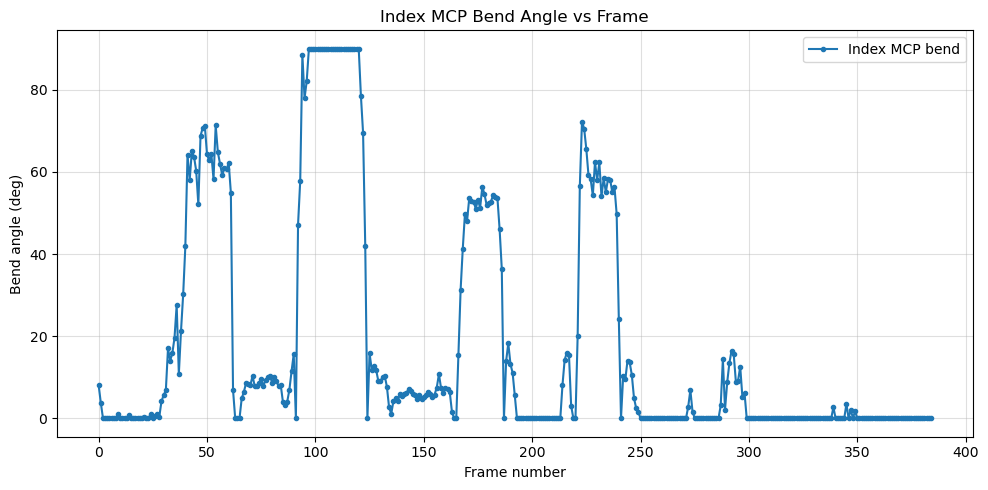

In [172]:
# Grab the angle column
angles = df_out[("metric","mcp_bend_deg","deg")]

# X-axis: frame numbers (or filenames if you prefer)
frames = range(len(angles))   # 0,1,2,...
# If you prefer the frame file names (from df_out.index), do:
# frames = df_out.index  

plt.figure(figsize=(10,5))
plt.plot(frames, angles, marker="o", linestyle="-", markersize=3, label="Index MCP bend")

plt.xlabel("Frame number")
plt.ylabel("Bend angle (deg)")
plt.title("Index MCP Bend Angle vs Frame")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

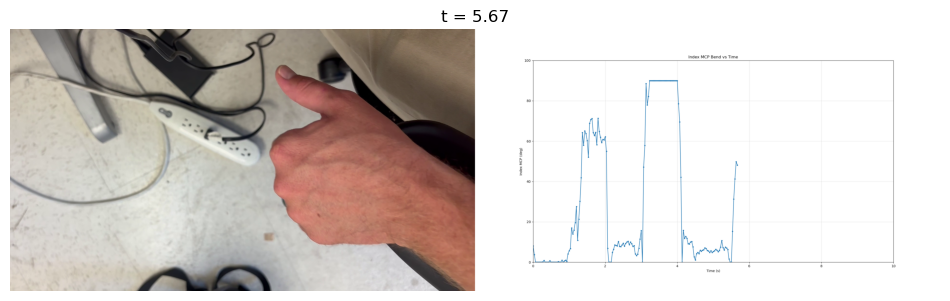

In [ ]:
# --- CONFIG (edit paths if needed) ---
VIDEO_PATH   = r"C:\flir_capture\calibration\tom_hand_media_pipe\tom_hand.mov"
OUTPUT_VIDEO = r"C:\flir_capture\calibration\tom_hand_media_pipe\tom_hand_with_plot.mp4"
USE_TIME_AXIS = True   # True: seconds on x-axis, False: frame #
Y_LIM = (0, 100)       # y-axis range in degrees

# --- Imports for this cell only ---
import os, math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from IPython.display import clear_output
import pandas as pd

assert os.path.exists(VIDEO_PATH), f"Video not found: {VIDEO_PATH}"
assert ("metric","mcp_bend_deg","deg") in df_out.columns, "Angle column missing in df_out."

# Pull your angles Series
angles = pd.to_numeric(df_out[("metric","mcp_bend_deg","deg")], errors="coerce").to_numpy()

# Open video
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f"Could not open {VIDEO_PATH}"
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
N_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or len(angles)
N = min(len(angles), N_video)  # keep streams aligned

# Prepare writer for side-by-side output
comp_W, comp_H = W*2, H
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (comp_W, comp_H))

# Precompute x-axis
x_full = (np.arange(N)/fps) if USE_TIME_AXIS else np.arange(N)

# UI update cadence
SHOW_EVERY = max(1, int(fps // 5))  # about 5 updates/sec

i = 0
while i < N:
    ok, frame_bgr = cap.read()
    if not ok:
        break

    # Build a fresh plot image (same size as video frame)
    fig = plt.figure(figsize=(W/100, H/100), dpi=100)
    ax = fig.add_subplot(111)

    # Mask finite values up to current frame
    y = angles[:i+1]
    x = x_full[:i+1]
    m = np.isfinite(y)

    # Draw line + points
    if m.any():
        ax.plot(x[m], y[m])
        ax.scatter(x[m], y[m], s=8)
    ax.set_xlabel("Time (s)" if USE_TIME_AXIS else "Frame")
    ax.set_ylabel("Index MCP (deg)")
    if Y_LIM: ax.set_ylim(*Y_LIM)
    if USE_TIME_AXIS:
        # show last ~10s for readability; comment out to show full span
        span = 10.0
        xmin = max(0.0, x_full[i] - span)
        ax.set_xlim(xmin, xmin + span)
    ax.grid(True, alpha=0.4)
    ax.set_title("Index MCP Bend vs " + ("Time" if USE_TIME_AXIS else "Frame"))

    canvas = FigureCanvas(fig)
    canvas.draw()
    plot_rgb = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    plot_rgb = plot_rgb.reshape(canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    # Ensure plot image matches video HxW
    if plot_rgb.shape[0] != H or plot_rgb.shape[1] != W:
        plot_rgb = cv2.resize(plot_rgb, (W, H), interpolation=cv2.INTER_AREA)

    # Compose side-by-side (left: original video, right: plot)
    plot_bgr = cv2.cvtColor(plot_rgb, cv2.COLOR_RGB2BGR)
    comp = np.hstack([frame_bgr, plot_bgr])

    # Write to file
    writer.write(comp)

    # Live display every few frames
    if i % SHOW_EVERY == 0:
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))
        plt.imshow(cv2.cvtColor(comp, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"{'t' if USE_TIME_AXIS else 'frame'} = {x_full[i]:.2f}" if USE_TIME_AXIS else f"frame = {i}")
        plt.show()

    i += 1

cap.release()
writer.release()
print(f"Done. Saved side-by-side video to:\n{OUTPUT_VIDEO}")
